In [1]:
from typing import Callable, Optional, List
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Canvas

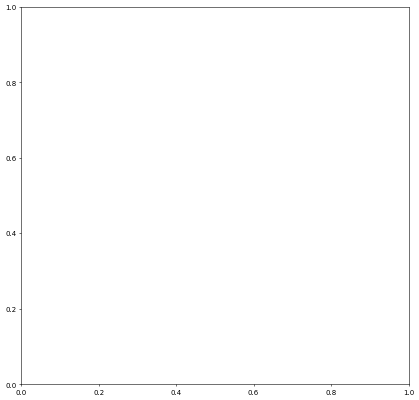

In [24]:
import matplotlib.pyplot as plt

class Canvas:
    def __init__(
        self,
        background: List[int] = np.array([[0, 0, 0, 0]]),
        dimensions: List=(15, 10),
        shake_every: float=0,
        dpi: int = 100,
        xlim:List=(-500, 500),
        ylim:List=(-400, 400)
    ):
        self.background = background
        self.dimensions = dimensions
        self.shake_every = shake_every
        self._figure, self._axes = plt.subplots(figsize=dimensions, dpi=dpi, facecolor=background)
        self._figure.set_size_inches(dimensions[0], dimensions[1])
        # self.scatter_points([[0.5,0.5]], [background], [0])
        # self._frame = self.frame
        self.xlim = xlim
        self.ylim = ylim

    def scatter_points(self, points: np.ndarray, colors: np.ndarray, sizes: np.ndarray):
        for point,color,size in zip(points, colors, sizes):
            color=color/255
            self._scatter = self._axes.scatter(point[0], point[1], color=color, s=size)
            self._axes.set_facecolor(self.background/255)
            self._axes.set_xlim(self.xlim[0], self.xlim[1])
            self._axes.set_ylim(self.ylim[0], self.ylim[1])
            # self._axes.set_aspect('equal')
            
        self._figure.canvas.draw()
    
    
        
    @property
    def frame(self):
        return self._figure.canvas.renderer.buffer_rgba()      
        # return self._canvas.astype(np.uint8)
canvas = Canvas(background=np.array([[1, 1, 1]]), dimensions=(10, 10), dpi=50)

x_orig = 50
y_orig = 50
rad_orig = 500
x_update = lambda x, t: x+t #np.random.randomnp.random.choice([-1, 1, 0]) #np.sin(t*x)/(x*t)
y_update = lambda x,t: (x+t)*np.sin((x+t)*np.pi/180)#np.random.choice([-1, 1, 0]) #np.sin(t*x)/(x*t)
rad_update = lambda x,t: max(300, x-t) *np.random.random()# np.random.choice([-1, 1, 0]) #np.sin(t)
color_orig = [255, 0, 0, 255]
color_update = lambda x,t: x-x/t

pts = 500

coord = np.array([(x_update(x_orig, i), y_update(y_orig, i)) for i in range(1, pts)])
rad = np.array([rad_update(rad_orig, i) for i in range(1, pts)])
color = np.array([[color_update(c, i) for c in color_orig] for i in range(1, pts)])
# canvas.scatter_points(coord, color, rad)

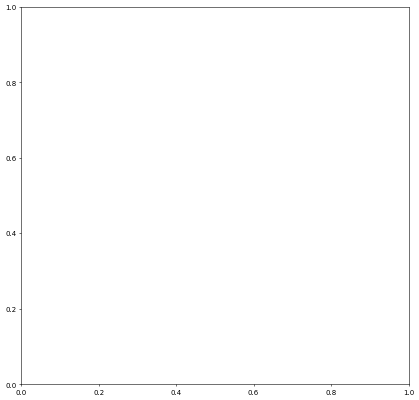

In [25]:
canvas._figure

In [26]:
canvas._figure.show()

<ipython-input-26-366daf1800ea>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  canvas._figure.show()


## Particle

In [27]:
from dataclasses import dataclass, field
from typing import Callable, List, Optional
import numpy as np

@dataclass
class Particle:
    x: int = 100
    y: int = 100
    z: int = 500
    x_update: Optional[Callable] = field(default_factory=lambda: [lambda x, t: x+t])
    y_update: Optional[Callable] = field(default_factory=lambda: [lambda x, t: (x)*np.sin((x+t)*np.pi/180)])
    z_update: Optional[Callable] = field(default_factory=lambda: [lambda x, t: max(1,x-t)])
    lifespan: int = 100
    color: List[int] = field(default_factory=lambda: [255, 0, 0, 255])
    color_update: Optional[List[Callable]] = field(default_factory=lambda: [lambda x, t: min(max(0, x - t), 255)])
    num_subparticles: Optional[int] = 2
    subparticles_every: Optional[int] = 2
    _time: int = 0
    _current_color: List[int] = field(default_factory=lambda: [255, 0, 0, 255])
    _position: List[int] = field(default_factory=lambda: [100, 100, 2])
    is_alive: bool = True

    def __init__(
        self,
        x: int = 100,
        y: int = 100,
        z: int = 500,
        x_update: Optional[Callable] = None,
        y_update: Optional[Callable] = None,
        z_update: Optional[Callable] = None,
        lifespan: int = 100,
        color: List[int] = [255, 0, 0, 255],
        color_update: Optional[List[Callable]] = [lambda x, t: min(max(0, x - t), 255)],
        num_subparticles: Optional[int] = 2,
        subparticles_every: Optional[int] = 2,
        _time: int = 0,
        _current_color: List[int] = [255, 0, 0, 255],
        _position: List[int] = [100, 100, 2],
        is_alive: bool = True,
    ) -> None:
        self.x = x
        self.y = y
        self.z = z
        self.x_update = x_update
        self.y_update = y_update
        self.z_update = z_update
        self.lifespan = lifespan
        self.color = color
        self.color_update = color_update
        self.num_subparticles = num_subparticles
        self.subparticles_every = subparticles_every
        self._time = _time
        self._current_color = _current_color
        self._position = (x,y,z)
        self.is_alive = is_alive

    def update_position(self, time: float):
        x = self.x if self.x_update is None else self.x_update(self.x, time)
        y = self.y if self.y_update is None else self.y_update(self.y, time)
        z = self.z if self.z_update is None else self.z_update(self.z, time)

        return [x, y, z]

    def update_color(self, time: float):
        color = self.color
        if self.color_update is None:
            pass
        elif len(self.color_update) == 1:
            fxn = self.color_update[0]
            color = [fxn(c, time) for c in color]
        else:
            color = [upd(c, time) for upd, c in zip(self.color_update, color)]
        return [int(c) for c in color]

    def update(self):
        sub_particles = []
        if self._time <= self.lifespan:
            self._position = self.update_position(self._time)
            self._current_color = self.update_color(self._time)
            sub_particles = [self]
            if self.subparticles_every == 0:
                return sub_particles
            if self._time % self.subparticles_every == 0:
                if self.num_subparticles is not None:
                    for p in range(self.num_subparticles):
                        p = Particle(
                            self._position[0],
                            self._position[1],
                            self._position[2],
                            self.x_update,
                            self.y_update,
                            self.z_update,
                            self.lifespan,
                            self._current_color,
                            self.color_update,
                            int(self.num_subparticles // 2),
                            int(self.subparticles_every // 2),
                        )
                        sub_particles.append(p)
        else:
            self.is_alive = False
        self._time += 1
        return sub_particles

# Example usage:
particle = Particle()
particle.update()
print(particle)


Particle(x=100, y=100, z=500, x_update=None, y_update=None, z_update=None, lifespan=100, color=[255, 0, 0, 255], color_update=[<function Particle.<lambda> at 0x000001B1205244C0>], num_subparticles=2, subparticles_every=2, _time=1, _current_color=[255, 0, 0, 255], _position=[100, 100, 500], is_alive=True)


## Smoke

In [28]:
class Smoke:
    def __init__(
        self,
        origin: List = [100, 100],
        lifespan: int = 100,
        color: List = [255, 0, 0, 255],
        start_particles: int = 5,
        max_particle_size:int=100
    ):
        self.color = color
        self.origin = origin
        self.lifespan = lifespan
        self.start_particles = start_particles
        self.particles: Optional[List[Particle]] = []
        self._time = 0
        self.is_alive = True
        self.max_particle_size=max_particle_size
        self._startup()
    
    @property
    def num_particles(self):
        return len(self.particles)

    def _startup(self):
        for sp in range(self.start_particles):
            p = Particle(
                x=self.origin[0]+np.random.randint(-10, 10),
                y=self.origin[1]+np.random.randint(-10, 10),
                z=self.max_particle_size+np.random.randint(-100, 100),
                lifespan=np.random.randint(self.lifespan/2, self.lifespan),
                x_update=lambda x, t: x + t+np.random.choice([-1, 1, 0]),
                y_update=lambda x, t: (x+t)*np.sin((x+t)*np.pi/180),
                num_subparticles=np.random.randint(0,3),
                color=self.color,
                subparticles_every=np.random.randint(0,2))
            self.particles.append(p)

    def update(self):
        temp_particles = []
        if self.lifespan >= self._time:
            for particle in self.particles:
                res = particle.update()
                if len(res) > 0:
                    temp_particles.extend(res)
                if not particle.is_alive:
                    del particle
                else:
                    temp_particles.append(particle)
        else:
            self.is_alive = False
        self.particles = temp_particles
        self._time += 1
        return self.particles


In [29]:
smoke = Smoke()

for i in range(5):
    smoke.update()
    print(smoke.num_particles)
    smoke.update()
    print(smoke.num_particles)

11
24
52
112
240
488
777
1542
3084
6168


## Playground

In [31]:
from matplotlib.animation import FuncAnimation
class PlayGround:
    def __init__(
        self, max_frames: int = 1000, smoke_origins: List = [(350, 500)]
    ):
        self.max_frames = max_frames
        self.smoke_origins = smoke_origins
        self.canvas:Canvas = Canvas(background=np.array([[1,1,1,1]])
        )
        self.smokes = [Smoke(origin=orig, color=[177,177,20,255], max_particle_size=500) for orig in smoke_origins]
        self.current_frame = 0
        self.is_alive = True

    @property
    def frame(self):
        return self.canvas.frame

    def update_frame(self, smoke: Smoke):
        points = []
        colors = []
        sizes = []

        for particle in smoke.particles:
            points.append(particle._position[:2])
            colors.append(particle.color)
            sizes.append(particle._position[2])
        
        self.canvas.scatter_points(np.array(points), np.array(colors), np.array(sizes))

    def update(self):
        temp_smokes = []
        if self.current_frame <= self.max_frames:
            for smoke in self.smokes:
                if not smoke.is_alive:
                    del smoke
                else:
                    temp_smokes.append(smoke)
                smoke.update()
                self.update_frame(smoke)
        else:
            self.is_alive = False
        self.current_frame+=1
        return self.frame
    def _animate(self, frame):
      self.update()
      return self.canvas._scatter,
    def animate(self, save_as:str='anim.gif'):
      ani = FuncAnimation(self.canvas._figure, self._animate, frames=self.current_frame, 
            interval=5, blit=True)
      ani.save(save_as, writer='pillow', fps=5)
      



In [32]:
pg = PlayGround(smoke_origins=[(350, 500)])
pg.current_frame=10
pg.animate()

In [48]:
24/255, 46.8/255, 48.2/255

(0.09411764705882353, 0.18352941176470586, 0.18901960784313726)

## MPL Anim

<IPython.core.display.Javascript object>

MovieWriter imagemagick unavailable; using Pillow instead.
